<a href="https://colab.research.google.com/github/GubioGL/Optics/blob/main/Gaus_com_fase_circular_de_posi%C3%A7%C3%A3o_e_valor_aleat%C3%B3rio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Pacotes 
!pip install --upgrade LightPipes
from LightPipes import *
from matplotlib import image
from scipy.fft import fft2, ifft2 ,fftshift
from scipy import special
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import scipy

     |████████████████████████████████| 50 kB 2.5 MB/s 


Mudei a posição do circulo da fase 

In [ ]:
#Pedidno permissão para ter acesso ao drive
import PIL
from PIL import Image
from google.colab import drive
import random
drive.mount('/content/drive', True)
SLM  = Image.open('/content/drive/MyDrive/Colab Notebooks/Gubio/DD.png')

imgGray = SLM.convert('L')
imgGray.save('imgGray2.jpg')
imgGra  = plt.imread('imgGray2.jpg')
ri = imgGra/imgGra.max()

Mounted at /content/drive


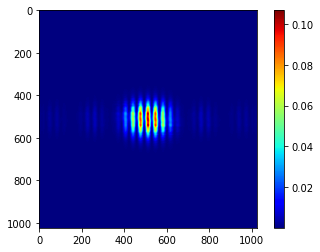

In [ ]:
########################################################################
n = 2**10
lamb = 512*nm        
k = 2*np.pi/lamb        
########################################################################
dx = 17*um  
x = np.arange(-n/2, n/2,1)*dx
y = np.arange(-n/2, n/2,1)*dx
xx,yy = np.meshgrid(x,y)
########################################################################
dzPar = np.arange(1e-20,100,1)*cm  
z = dzPar[0]       
###############################################################################
N_inc = 100
i     = 0
SI    = [0]

while (i<N_inc):
  i+=1
###############################################################################
#### Perfil de Intensidade   
  w_0 = 1.6*mm         
  r    = np.sqrt(xx**2+yy**2) 
  z_R = np.pi*w_0**2/lamb 
  R    = z*(1+(z_R/z)**2)                                                
  w    = w_0*np.sqrt(1+(z/z_R)**2)
  GAUSSIAN = w_0/w*np.exp( -r**2/w**2-1j*k*r**2/(2*R))*np.exp(-1j*k*z)  # Campos Gaussianos

  F = Begin(2*abs(x[1]),lamb,n);    # Criando o Campo no Lpipe
  Fn = F.copy(F)
  Fn.field = GAUSSIAN            # Modulando a Campo criado

###############################################################################
### Criando a fase 
  R = 3*mm                        
  Cx = random.randrange(-3,3)*mm # Posição aleatória da fase
  A = CircAperture(R,Cx,Cx, F)    
  ftrm = random.random()*2*np.pi  
  AA = A.field*ftrm               
  ftm2 = random.random()*2*np.pi   
  BB = F.field                    
  CC = (BB-A.field)*ftm2          
  D = CC+AA

  #plt.imshow(abs(D),cmap='jet')
  ##plt.colorbar()
  #plt.show()                       
  ##### Alterando a antiga fase   ############  
  EE = SubPhase(D,Fn) 
  EEint = EE.field*ri             
  Fint = F.copy(F)
  Fint.field = EEint
  propagação = Forvard(60*cm,Fint)
  imagem = Intensity(0,propagação)
  
  #plt.imshow(imagem,cmap='jet')
  #plt.colorbar()
  #plt.show()

  #fase = Phase(EE)
  #plt.imshow(fase,cmap='jet')
  #plt.colorbar()
  #plt.show()
  
  SI = SI + imagem

imagem = SI/N_inc
   
plt.imshow(imagem,cmap='jet')
plt.colorbar()
plt.show()
##############################################################################

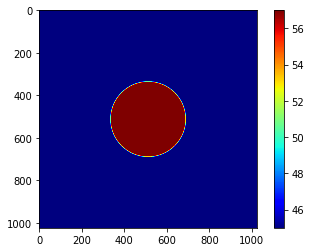

In [ ]:
### Criando a fase 
Raio = 3*mm                        
Cx = random.randrange(-3,3)*mm # Posição aleatória da fase
A = CircAperture(Raio,Cx,Cx, F)    
ftrm = random.random()*2*np.pi  
AA = A.field*ftrm               
ftm2 = random.random()*2*np.pi  
BB = F.field                    
CC = (BB-A.field)*ftm2          
D = CC+AA

plt.imshow(abs(D),cmap='jet')
plt.colorbar()
plt.show()           

In [ ]:
# Ajustado para analisar na Direita e esquerda
### Função da Suavização #########################
def SUAVE(media, linha):
  novalista = []
  for i in range(media ,1024,1):
    b = imagem[linha,i-media:i]
    AA = sum(b)/media
    novalista.append(AA)
  return np.array(novalista)

def MM(suavizar,linha):
  maxi2 = SUAVE(suavizar,linha).max()
  posiçao2 = 0
  for i in SUAVE(suavizar,linha):
    if i == maxi2:
      break 
    posiçao2 +=1 

#### Encontrar o valor mínimo local a Direita parti do maximo global
  mini = 0
  Vimax = SUAVE(suavizar,linha)[posiçao2:1024]
  for i in range(len(Vimax)):
    if i == len(Vimax)-1:
      break
    if Vimax[i] > Vimax[i+1]:
      mini = Vimax[i+1]
    elif Vimax[i] < Vimax[i+1]:
      mini = Vimax[i]
      break   
  # Vamos encontrar o posição no qual temos mínimo
  PMin = 0 
  for i in Vimax:
    if i == mini:
      break 
    PMin += 1  
  posiçaomin = posiçao2 + PMin -1
#######################################################################
#### Encontrar o valor mínimo local a ESQUERDA a parti do maximo lobal
  miniE = 0
  xamiV = SUAVE(suavizar,linha)[0:posiçao2]
#########################################################
  for i in range(len(xamiV)):
    i += 1
    if i == len(xamiV)-1:
      break
    if xamiV[-i] > xamiV[-i-1]:
      miniE = xamiV[-i-1]
    elif xamiV[-i] < xamiV[-i-1]:
      miniE = xamiV[-i]
      break   
  # Vamos encontrar o posição no qual temos mínimo
  PMinE = 0 
  for i in range(len(xamiV)):
    i+=1
    if xamiV[-i] == miniE: 
      break 
    PMinE += 1  
  posiçaominE = posiçao2 - PMinE

  if miniE > mini:
    posiçaomin = posiçaominE
    mini       = miniE
  # [0] = Valor max,[1] = Posição max ,[2] = Valor Min,[3] = Posição Min
  return maxi2, posiçao2, mini, posiçaomin  #,miniE, posiçaominE 

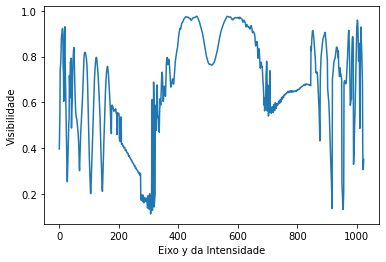

In [ ]:
# A VISIBILIDADE TODA
VisibilidadeN = []

for j in range(0,1024):
  V = ( MM(3,j)[0] - MM(3,j)[2] )/( MM(3,j)[0]  + MM(3,j)[2])
  VisibilidadeN.append(V) 
  
plt.plot(VisibilidadeN) 
plt.xlabel('Eixo y da Intensidade')
plt.ylabel("Visibilidade")
plt.show()


(3.399311498594751e-05, 1006, 1.1982700839012153e-06, 1015)


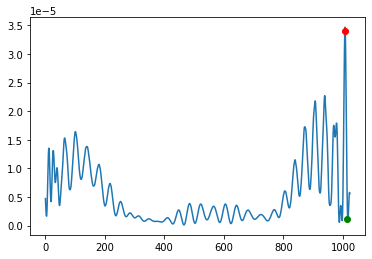

In [ ]:
qe =3
qw = 1000
print(MM(qe,qw))

# DISTRIBUIÇÃO DE INTENSIDADE

plt.plot(imagem[qw])
plt.plot(MM(qe,qw)[1] , MM(qe,qw)[0] , 'o', color ='red'  )
plt.plot(MM(qe,qw)[3] , MM(qe,qw)[2] , 'o', color ='green'  )
plt.show()